In [ ]:
pip install pandas

In [1]:
import os
import pandas as pd
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline 

labels = pd.read_csv(
    "../train.csv",
    names=['ID', 'Class']
)
train_files = glob('{}/data/Train/*.wav'.format(os.path.abspath('../')))

ModuleNotFoundError: No module named 'pandas'

In [2]:
def data_to_spec(data):
    D = librosa.stft(data)
    return librosa.power_to_db(np.abs(D)**2, ref=np.median)

def file_to_spec(filename):
    data, rate = librosa.load(filename)
    return data_to_spec(data)

def file_to_label(filename):
    fname = os.path.basename(filename)
    cid = fname.replace('.wav', '')
    classname = labels.loc[labels['ID'] == cid]
    return classname.values.tolist()[0][1] 

def show_file(filename):
    plt.title(file_to_label(filename))
    librosa.display.specshow(file_to_spec(filename), x_axis='time', y_axis='linear');
    plt.colorbar(); 

In [6]:
# Tam boyutlu spektrogramı görselleştirir

file = train_files[13]
sp = file_to_spec(file)
print(np.amin(sp), np.amax(sp))
show_file(file)                        

-24.284554 55.715446


In [260]:
siren = file_to_spec(file)
print('spectrogram shape:', siren.shape)

spectrogram shape: (1025, 173)


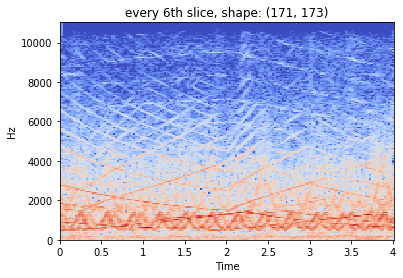

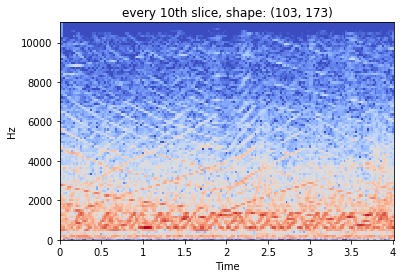

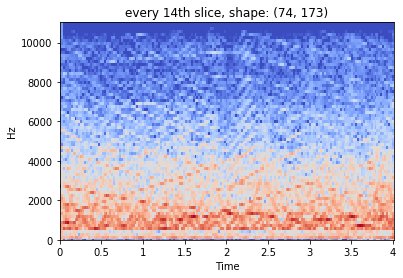

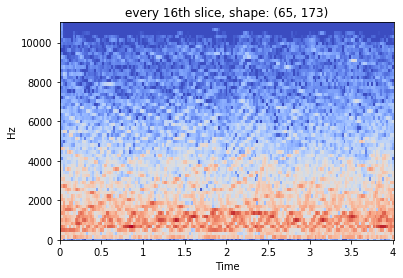

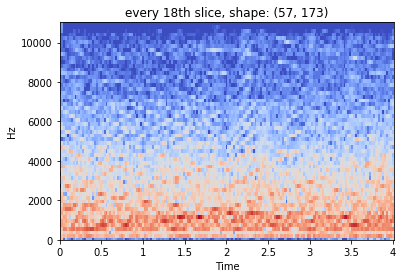

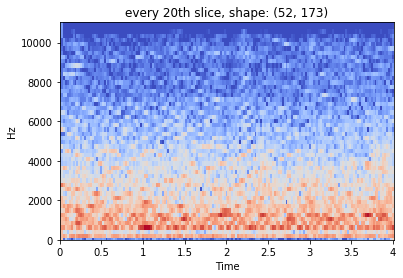

In [261]:
import humanize
#Frekans bantlarını farklı faktörlerde kırıp işler
n = 2
for i in range(0,10):
    fig = plt.figure()
    downsized = siren[::n,]
    plt.title("every {} slice, shape: {}".format(humanize.ordinal(n), downsized.shape))
    librosa.display.specshow(downsized, x_axis='time', y_axis='linear')
    n+=2

In [262]:
#from scipy import stats
#stats.describe(spec[0])

Şimdi bir araba korna sesi düşüneceğiz. Uzunluğu çok daha kısa, 1/2 saniyeden az. Tüm seslerim (.4,4) saniye veya bir saniyeden az ile 4 saniye arasında. Süre en kısa uzunluktaki ses örneğiyle eşleşene kadar veya daha kısa spektrogramlardaki süreyi tam dört saniyeye eşit olacak şekilde uzatılacak. 

spec shape: (1025, 9)
audio samples: (4574,)


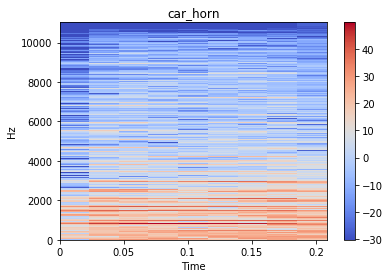

In [263]:
# Araba korna sesi hakkında bilgi
horn_file = train_files[11]
horn = file_to_spec(horn_file)
print("spec shape:", horn.shape)
print("audio samples:", librosa.load(horn_file)[0].shape)
show_file(horn_file)  

In [264]:
ipd.Audio(horn_file)

In [ ]:
# At this resolution it's pretty easy to see
# the correlation between the numbers in the array and and the graph. 
horn

: 

In [266]:
horn.shape

(1025, 9)

In [267]:
from scipy import signal
print(horn[0])
#signal.resample(horn, 1025,73)


[17.339193  14.539494  30.473139  26.169077  21.603485  17.833673
 24.315796  -8.913864  14.3094845]


In [268]:
# Let's resample
upsampled_horn = signal.resample(horn, 173, axis=1)

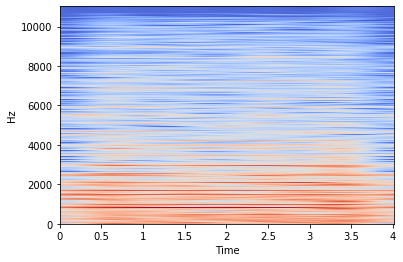

In [269]:
librosa.display.specshow(upsampled_horn, x_axis='time', y_axis='linear')

That looks nice, but will the smooth transition between time slices help or hurt when training on this data?  


Also consider 
* repeating 
* time stretching 

In [270]:
# I need a method that repeats based on the number of buckets I end up with

#horn_with_repeats = np.repeat(horn, 173, axis=1)

In [271]:
#librosa.display.specshow(horn_with_repeats, x_axis='time', y_axis='linear')

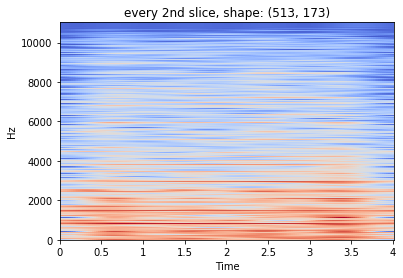

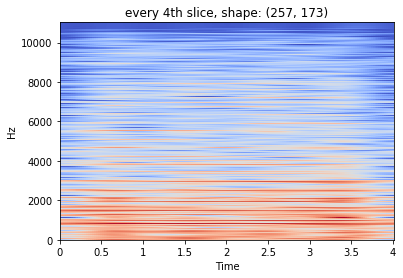

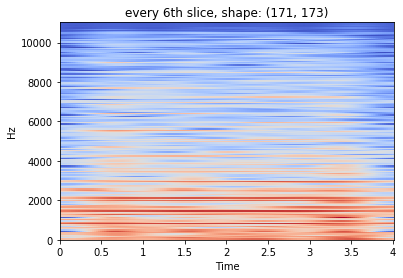

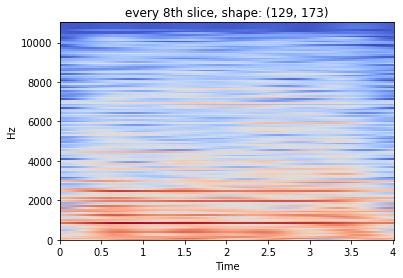

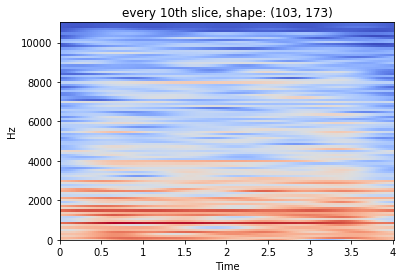

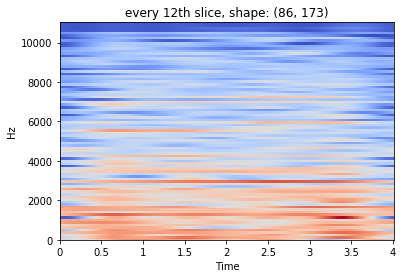

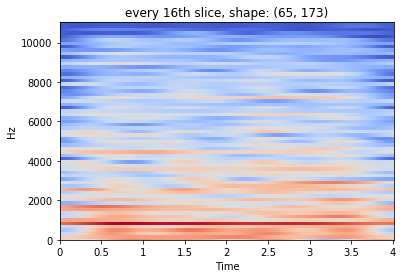

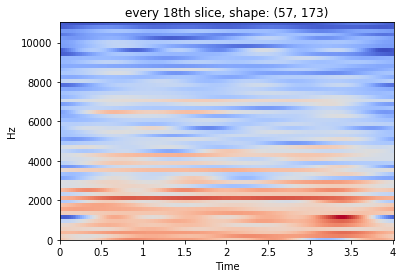

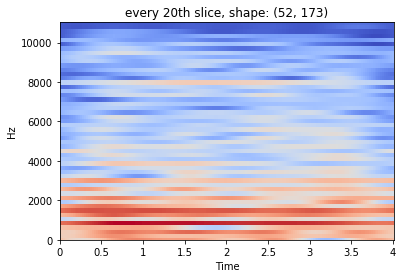

In [272]:
#  Now that I have the correct timeslice length, 
#  I decimate frequency bands at different factors and render.  For this sound, I've effectively added
#  added rows to the X axis, and now I will subtract rows from the Y axis.
n = 2
for i in range(0,10):
    fig = plt.figure()
    downsized = upsampled_horn[::n,]
    plt.title("every {} slice, shape: {}".format(humanize.ordinal(n), downsized.shape))
    librosa.display.specshow(downsized, x_axis='time', y_axis='linear')
    n+=2

# Librosa has a time stretching function.  That's awesome!

In [251]:
#data, rate = librosa.load(train_files[12])
##ata, rate = librosa.load(train_files[15])
data, rate = librosa.load(horn_file)
ipd.Audio(data, rate=rate)

print(data.shape)

target_len = 88200

print(data.shape[0]/target_len)

stretched = librosa.effects.time_stretch(data, rate=data.shape[0]/target_len)
stretched = stretched[:target_len:]
stretched.shape

(4574,)
0.051859410430839005


(88200,)

In [252]:
ipd.Audio(data, rate=rate)

In [253]:
ipd.Audio(stretched, rate=rate)


In [254]:
st = data_to_spec(stretched)

In [255]:
librosa.display.specshow(st, x_axis='time', y_axis='linear');

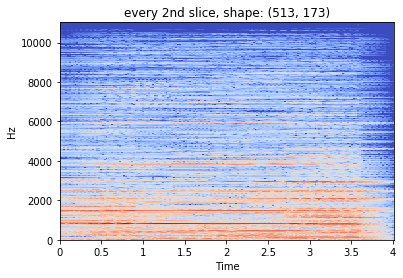

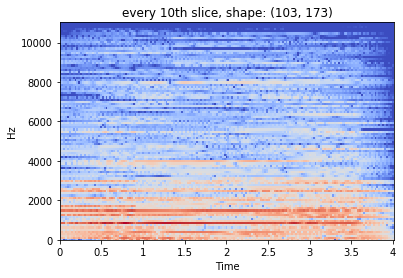

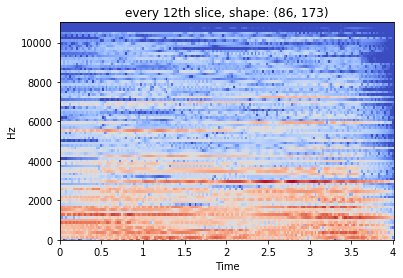

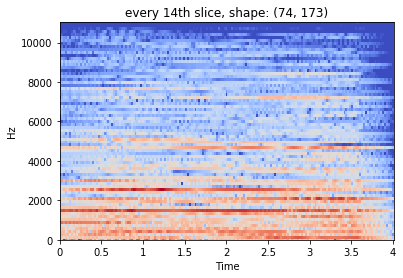

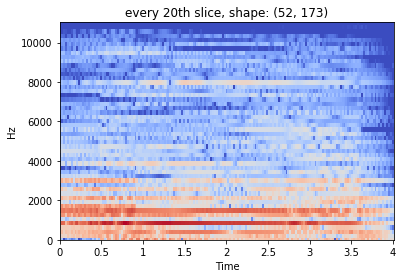

In [256]:
#  To be complete, decimate again
n = 2
for i in range(0,10):
    fig = plt.figure()
    downsized = st[::n,]
    plt.title("every {} slice, shape: {}".format(humanize.ordinal(n), downsized.shape))
    librosa.display.specshow(downsized, x_axis='time', y_axis='linear')
    n+=2